## Goal of notebook

This notebook accompanies [sSVN](https://github.com/leviyevalex/sSVN), and provides an example of how to run on the hybrid Rosenbrock. The hybrid Rosenbrock is a very convenient benchmark.
1. It is easily adapted to any number of dimensions $D \ge 2$.
2. Each marginal is a long and narrow ridge. These are notoriously difficult for sampling algorithms to resolve.
3. It may be analytically sampled, providing a computationally trivial way to compare the quality of samples obtained via various methods/algorithms.
4. Most importantly, it closely resembles many geometries often encountered in practice (e.g, https://arxiv.org/abs/2106.15163).

In this notebook we compare the performance of SVGD and sSVN on a ten-dimensional hybrid Rosenbrock. We encourage the reader to tinker with the settings of the hybrid Rosenbrock, `eps`, and `nParticles`. The reader will find that sSVN is much more stable than sSVGD. That is, sSVN may be evolved with a much larger `eps`.

## Import tools

In [1]:
import sys
sys.path.append("..")

from models.hybrid_rosenbrock import hybrid_rosenbrock
from src.samplers import samplers
from scripts.plot_helper_functions import collect_samples
import numpy as np
%matplotlib inline
import logging
import sys
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
import corner

## Setup hybrid Rosenbrock model

In [2]:
n2 = 3
n1 = 4
model = hybrid_rosenbrock(n2=n2, n1=n1, mu=1, a=30, b=np.ones((n2, n1-1)) * 20, id='')
ground_truth_samples = model.newDrawFromLikelihood(100000)

## Run sSVGD dynamics

Remark: sSVGD is unstable with eps=0.01. Try it!

In [4]:
nParticles = 100
kernelKwargs = {'kernel_type': 'RFG', 'nFeatures':nParticles}
sampler1 = samplers(model=model, nIterations=100, nParticles=nParticles, profile=False, kernelKwargs=kernelKwargs)
sampler1.apply(method='sSVN', eps=0.1, h=2*model.DoF)

TypeError: samplers.apply() missing 2 required positional arguments: 'kernelKwargs' and 'h'

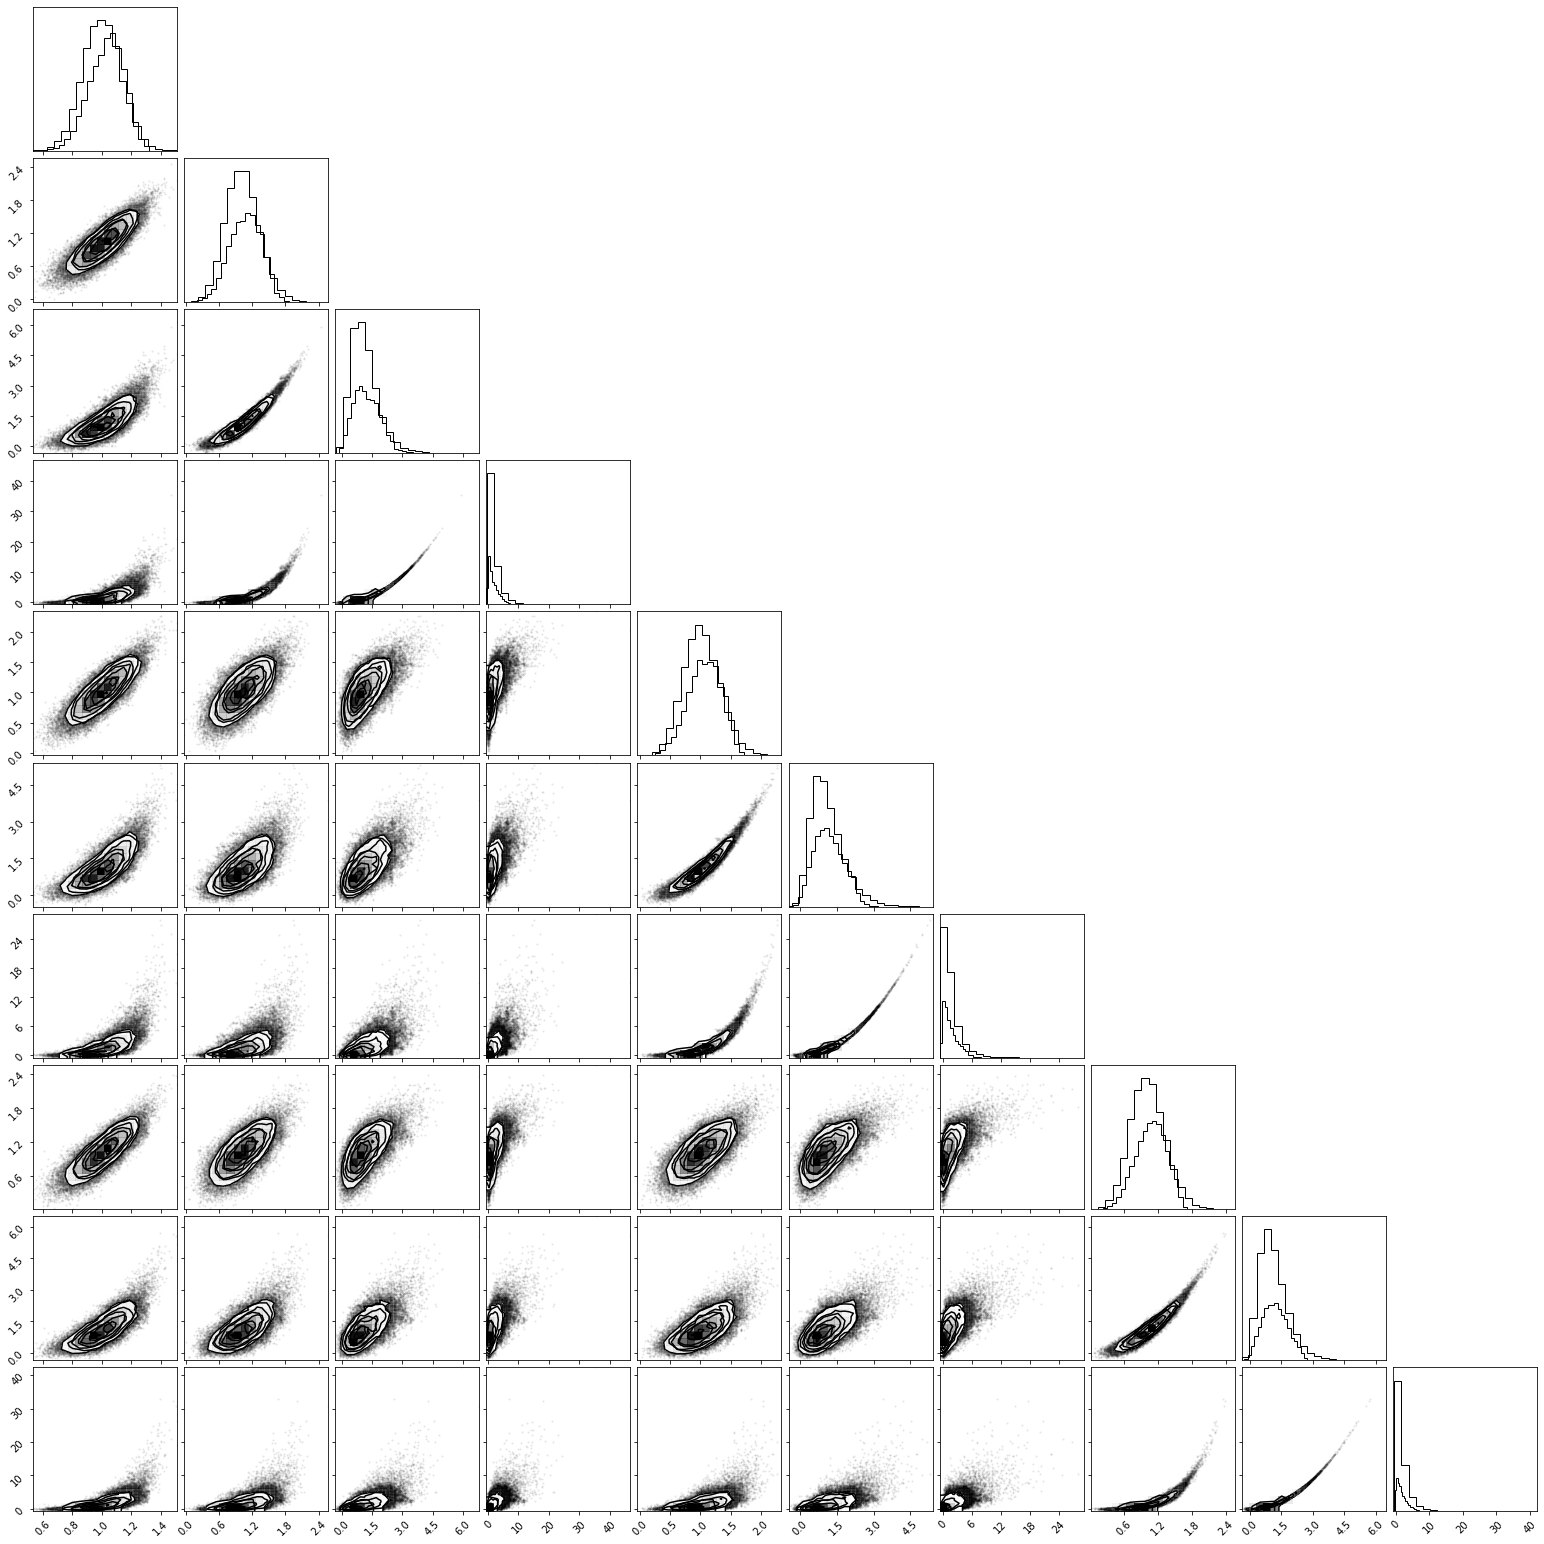

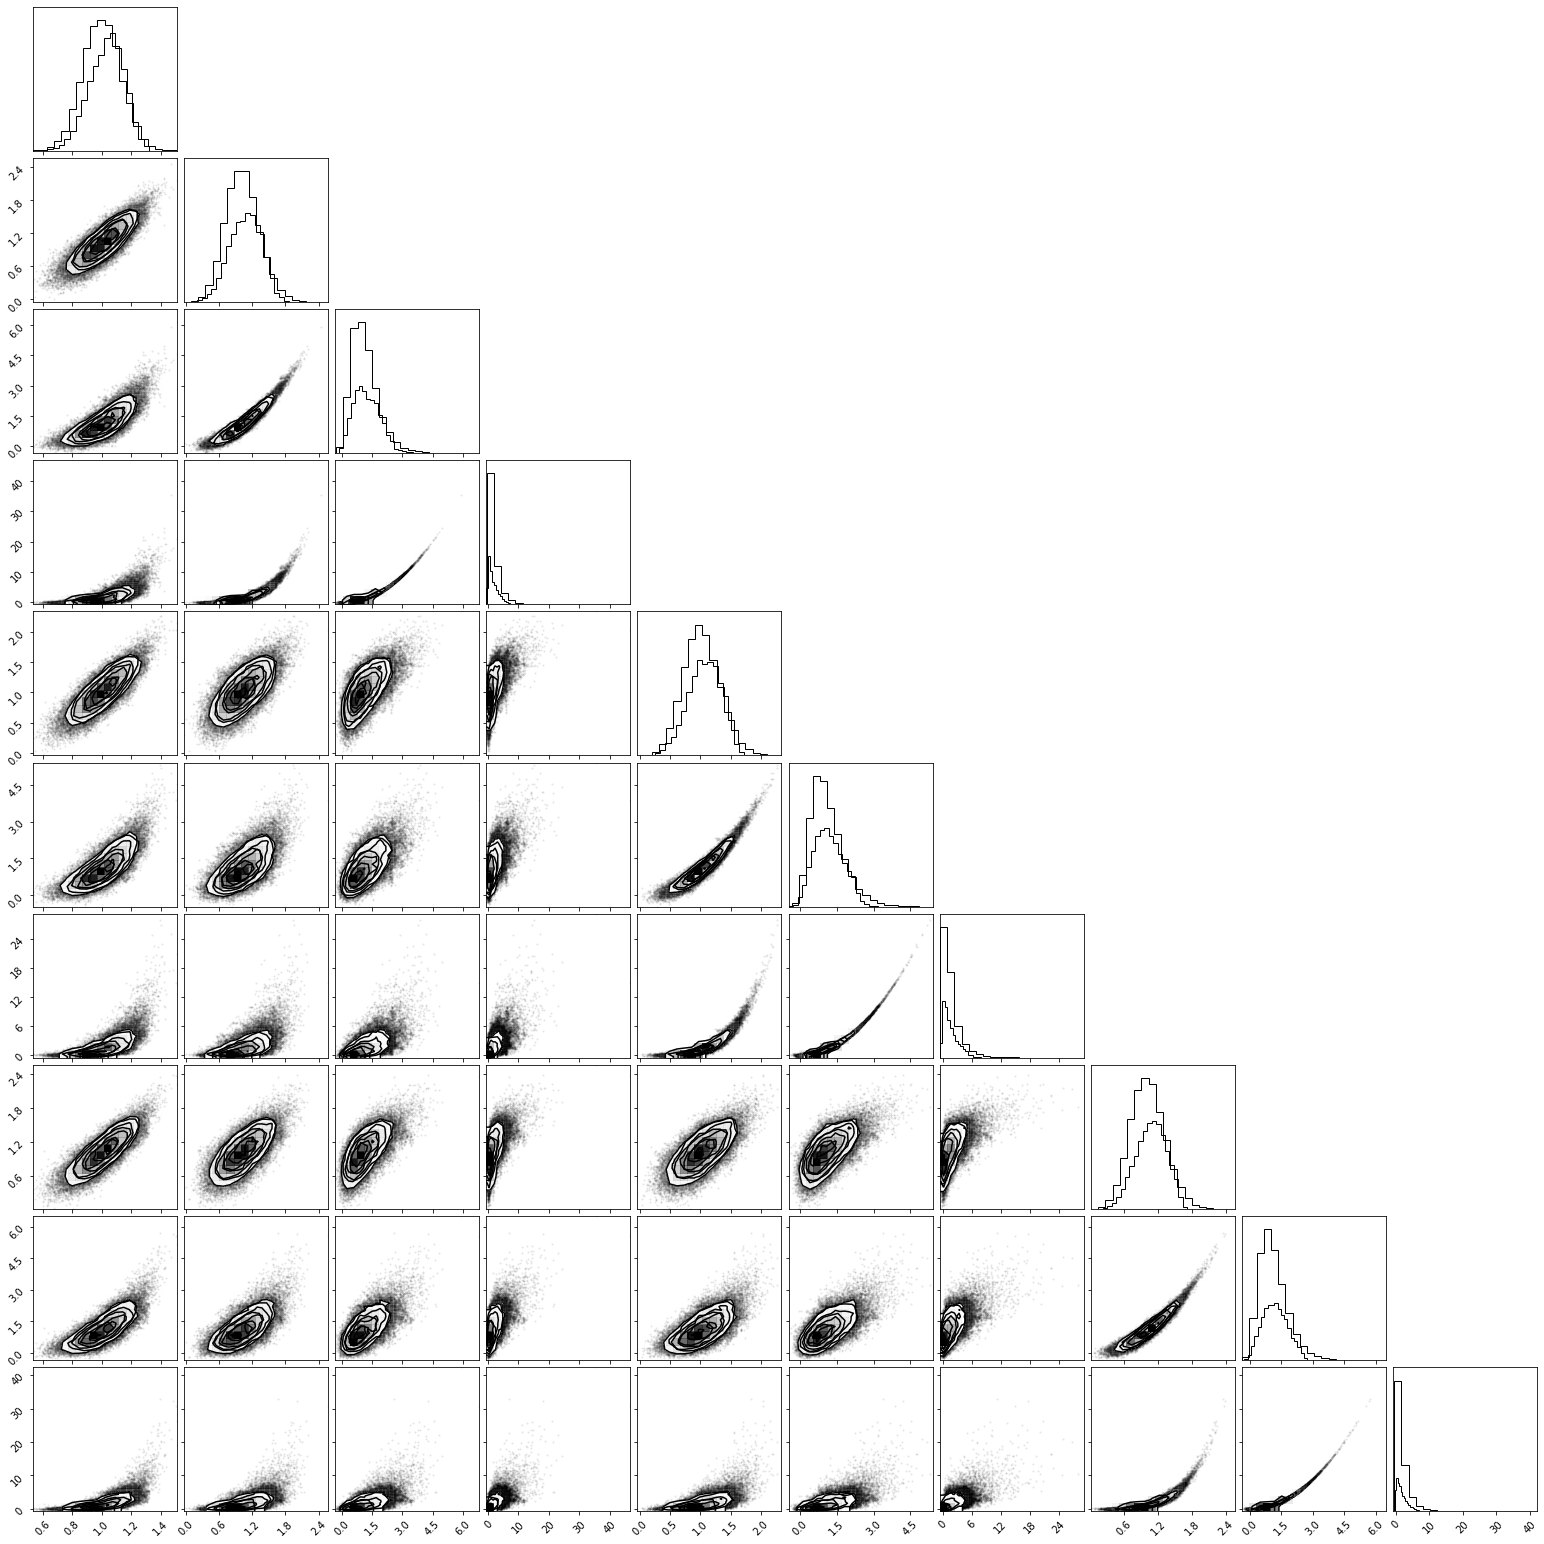

In [11]:
# %%capture
X1 = collect_samples(sampler1.history_path)
fig1 = corner.corner(X1)
corner.corner(ground_truth_samples[0:X1.shape[0]], fig=fig1)

## Run sSVN dynamics

In [44]:
sampler2 = samplers(model=model, nIterations=100, nParticles=100, profile=False)
sampler2.apply(method='sSVN', eps=0.1)

Stepsize 0.100000 | Median bandwidth: 2.261762: 100%|██████████| 100/100 [00:41<00:00,  2.41it/s]

INFO:src.samplers:OUTPUT: Run completed successfully! Data stored in:
 C:\Users\Alex\sSVN\outdir\1651865937\output_data.h5


In [45]:
%%capture
X2 = collect_samples(sampler2.history_path)
fig2 = corner.corner(X2)

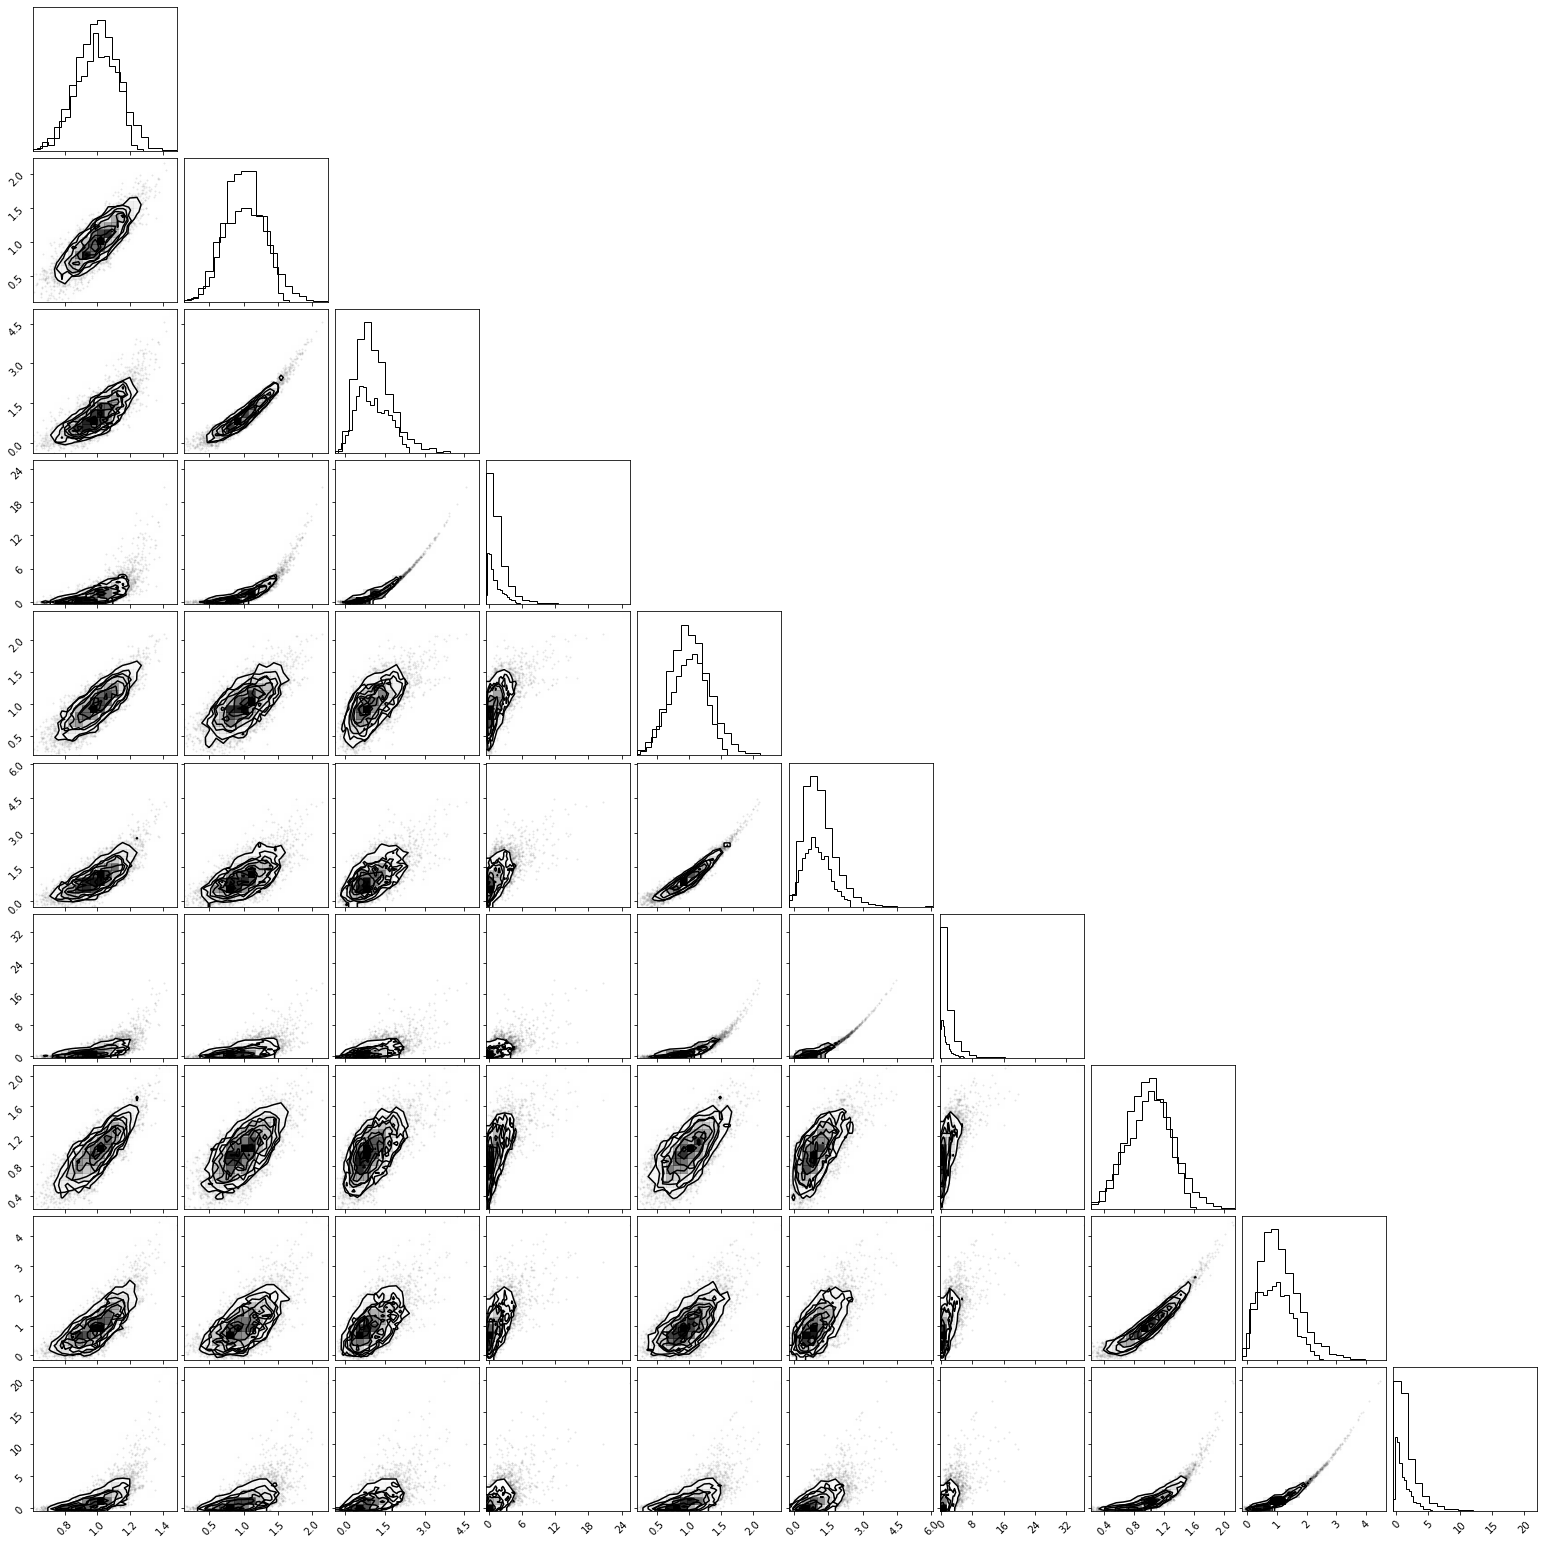

In [46]:
corner.corner(ground_truth_samples[0:X2.shape[0]], fig=fig2)